In [6]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils 
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

In [56]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'

In [10]:
pagedf = pd.read_feather(PROPHET_PATH+'pagedf.f')
ds = pd.read_feather(PROPHET_PATH+'ds.f')

## Version 0.3
Should set version directory name in next cell. Should describe version specifics (outliers, holidays, validation period)

* Val indexing on -60
* No outlier fixing
* Linear growth
* Truncating predictions at 0

### Remarks
* ?

In [12]:
# should break if the dir already exists - avoids accidental overwriting
VERSION = 'v0.3/'
val_lims = (0,-60)
os.makedirs(PROPHET_PATH+VERSION)

In [13]:
pagedf = pagedf.loc[:,:'10']

# WARNING:
Turned off the chained assignment warning - when slicing dfs they can return copies sometimes instead,
which will mean your assignment wont be done on the actual base df.
Not sure why it's still compaining at me when I'm using .loc for assignations everywhere... shitty

In [14]:
pd.options.mode.chained_assignment = None

In [27]:
def process_page(page):
    print(page)
    df = ds.join(pagedf[page])
    df.columns = ['ds','y']
    # note this is doing validation on last 60 days
    # should also consider doing validation on the time period we are forcasting
    traindf = df.iloc[val_lims[0]:val_lims[1]]
    traindf['train'] = 1 # feather won't serialize bool so 1s and 0s...
    # do outlier removal here
    #traindf.loc[traindf.y > traindf.y.quantile(.95), ['y']] = None
    m = Prophet(yearly_seasonality=True)
    m.fit(traindf)
    forecast = m.predict(ds)
    forecast['yhat_org'] = forecast['yhat']
    forecast.loc[forecast['yhat'] < 0,['yhat']] = 0.0
    forecast = forecast.join(df.y)
    forecast = forecast.join(traindf.loc[:,['train']]).fillna({'train':0}) # 0 bools
    #forecast.loc[forecast['train'] != 1,['train']] = 0 # 0 bools
    forecast.to_feather(PROPHET_PATH+VERSION+page+'df.f')
    with open(PROPHET_PATH+VERSION+page+'m.pk', 'wb') as file:
        pk.dump(m,file)
    full_smape = wiki.val.smape(forecast.y, forecast.yhat)
    val_smape = wiki.val.smape(forecast[forecast['train'] == 0].y,forecast[forecast['train'] == 0].yhat)
    return (page, full_smape, val_smape)

In [28]:
def wrapper(pages):
    val_results = []
    for page in tqdm(pages):
        val_results.append(process_page(page))
    return val_results

In [29]:
total_proc = mp.cpu_count()

In [30]:
col_split = np.array_split(pagedf.columns, total_proc)
mp_pool = mp.Pool(total_proc)

  0%|          | 0/3 [00:00<?, ?it/s]

3
6


  0%|          | 0/2 [00:00<?, ?it/s]

0
9


 33%|███▎      | 1/3 [00:02<00:04,  2.40s/it]

1


 33%|███▎      | 1/3 [00:02<00:04,  2.42s/it]

7


 33%|███▎      | 1/3 [00:02<00:04,  2.48s/it]

4
10


 67%|██████▋   | 2/3 [00:04<00:02,  2.44s/it]

8


 67%|██████▋   | 2/3 [00:04<00:02,  2.44s/it]

5
2


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/2 [00:00<?, ?it/s]

6
3
9


 33%|███▎      | 1/3 [00:02<00:04,  2.29s/it]

1


 50%|█████     | 1/2 [00:02<00:02,  2.36s/it]

10


 33%|███▎      | 1/3 [00:02<00:04,  2.41s/it]

4


 33%|███▎      | 1/3 [00:02<00:04,  2.46s/it]

7


 67%|██████▋   | 2/3 [00:04<00:02,  2.33s/it]

2


 67%|██████▋   | 2/3 [00:04<00:02,  2.39s/it]

5


 67%|██████▋   | 2/3 [00:04<00:02,  2.44s/it]

8


  0%|          | 0/3 [00:00<?, ?it/s]

3
0
9
6


 33%|███▎      | 1/3 [00:02<00:04,  2.40s/it]

1


 33%|███▎      | 1/3 [00:02<00:04,  2.46s/it]

7


 50%|█████     | 1/2 [00:02<00:02,  2.48s/it]

10


 33%|███▎      | 1/3 [00:02<00:05,  2.52s/it]

4


 67%|██████▋   | 2/3 [00:04<00:02,  2.38s/it]

2


 67%|██████▋   | 2/3 [00:04<00:02,  2.44s/it]

5


 67%|██████▋   | 2/3 [00:04<00:02,  2.42s/it]

8


100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


In [40]:
with utils.clock():
    %time val_results = mp_pool.map(wrapper, col_split)

CPU times: user 15.5 ms, sys: 10.6 ms, total: 26.1 ms
Wall time: 6.65 s
Elapsed time 6.6514809131622314 seconds


In [41]:
val_results = [item for sublist in val_results for item in sublist]
val_results = pd.DataFrame(val_results, columns=['page_index',VERSION[:-1]+'_full',VERSION[:-1]+'_val'])

In [60]:
val_results.to_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f')

(0, page_index          0
v0.3_full      50.762
v0.3_val      63.6313
Name: 0, dtype: object)


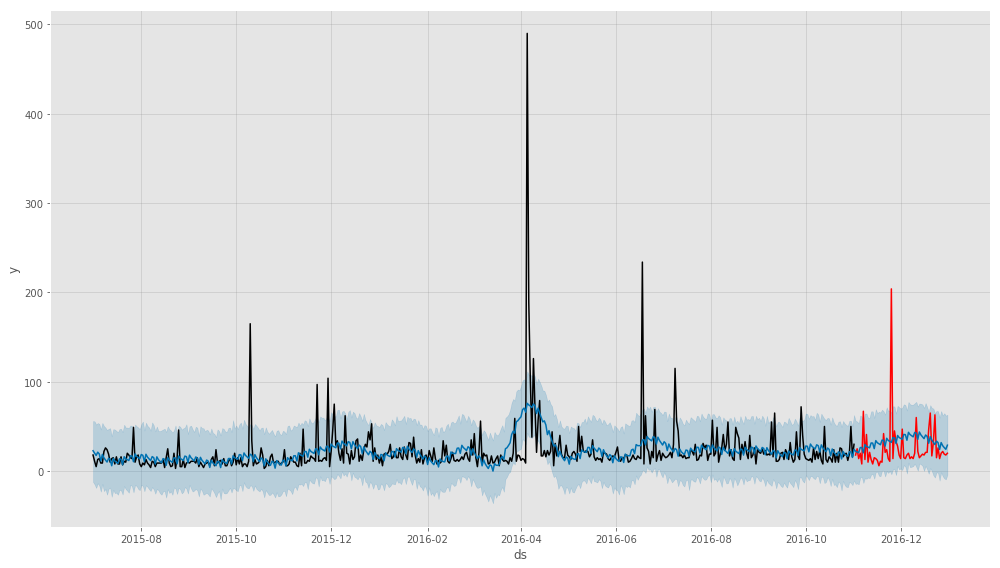

(1, page_index          1
v0.3_full     47.4787
v0.3_val      51.2935
Name: 1, dtype: object)


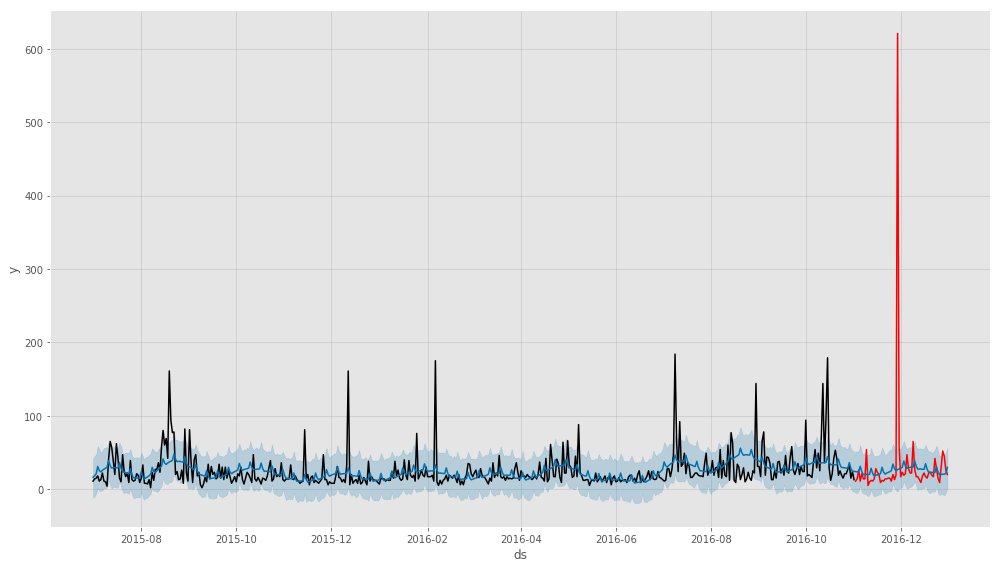

(2, page_index          2
v0.3_full     69.7709
v0.3_val      59.9164
Name: 2, dtype: object)


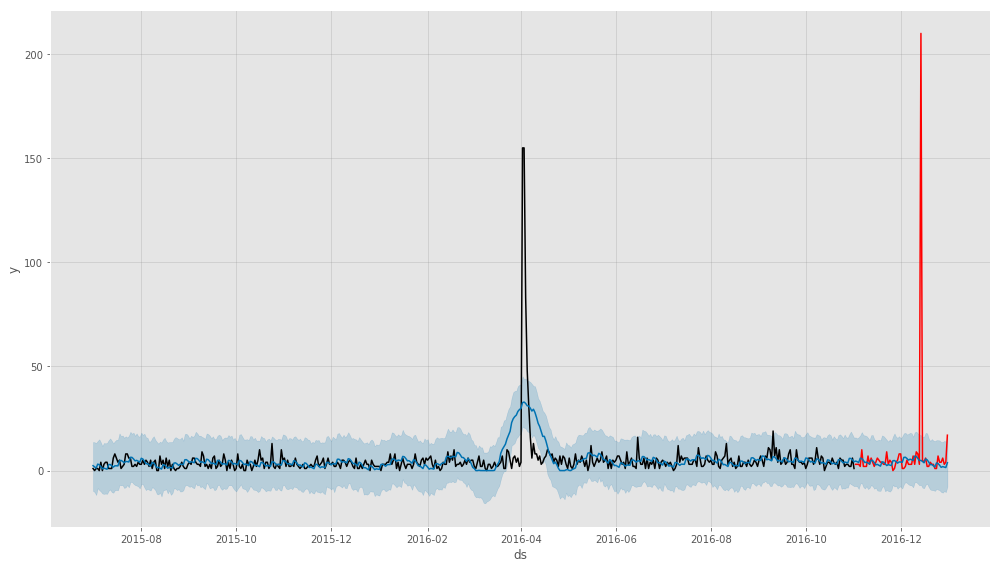

(3, page_index          3
v0.3_full     47.2946
v0.3_val      44.9128
Name: 3, dtype: object)


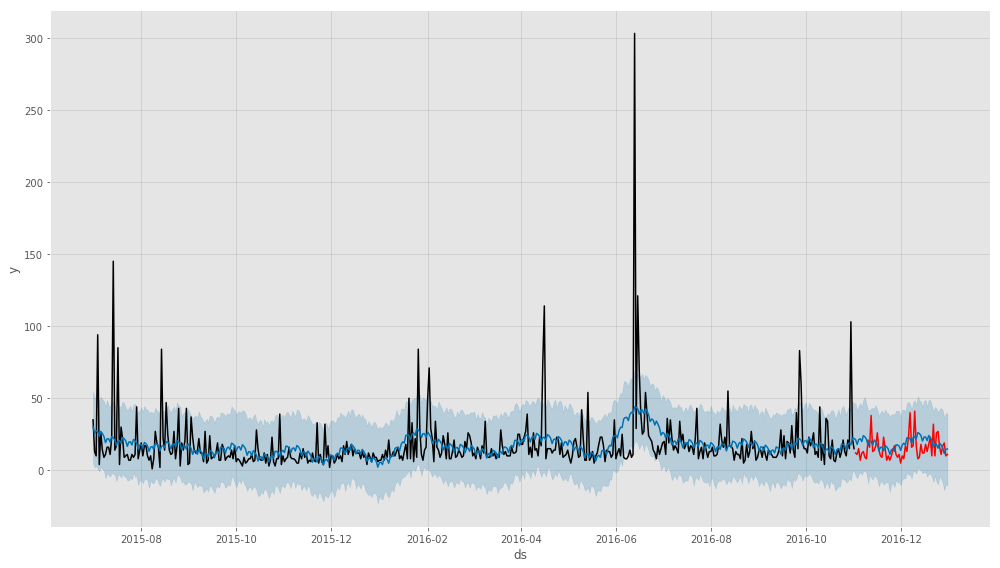

(4, page_index          4
v0.3_full     112.884
v0.3_val      147.782
Name: 4, dtype: object)


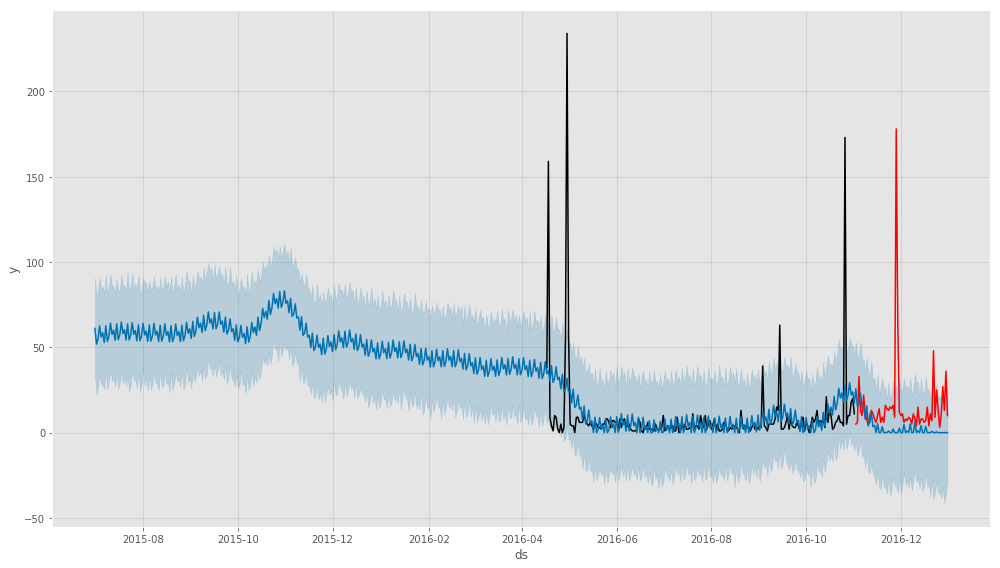

(5, page_index          5
v0.3_full     41.3125
v0.3_val      47.5155
Name: 5, dtype: object)


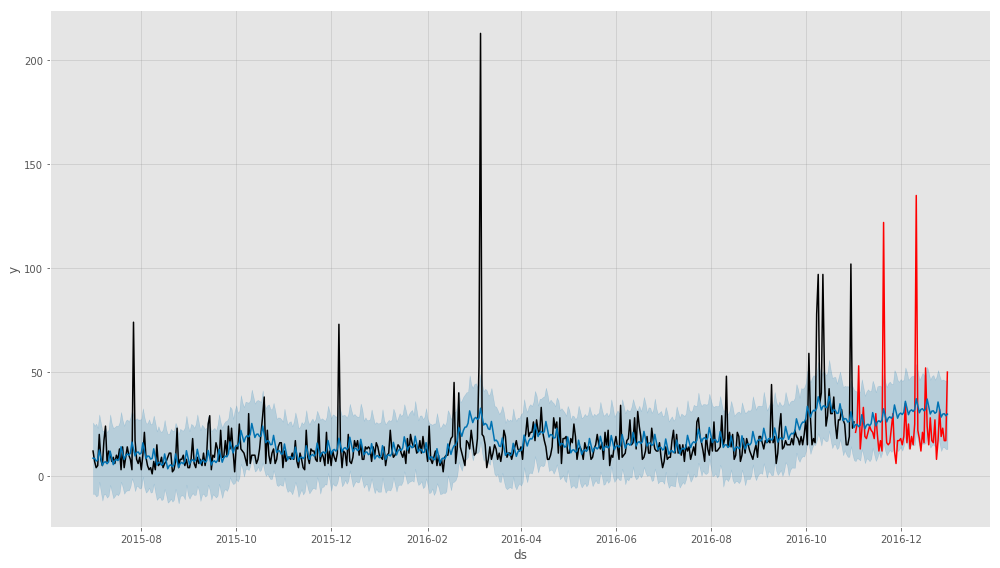

(6, page_index          6
v0.3_full     90.5289
v0.3_val      156.933
Name: 6, dtype: object)


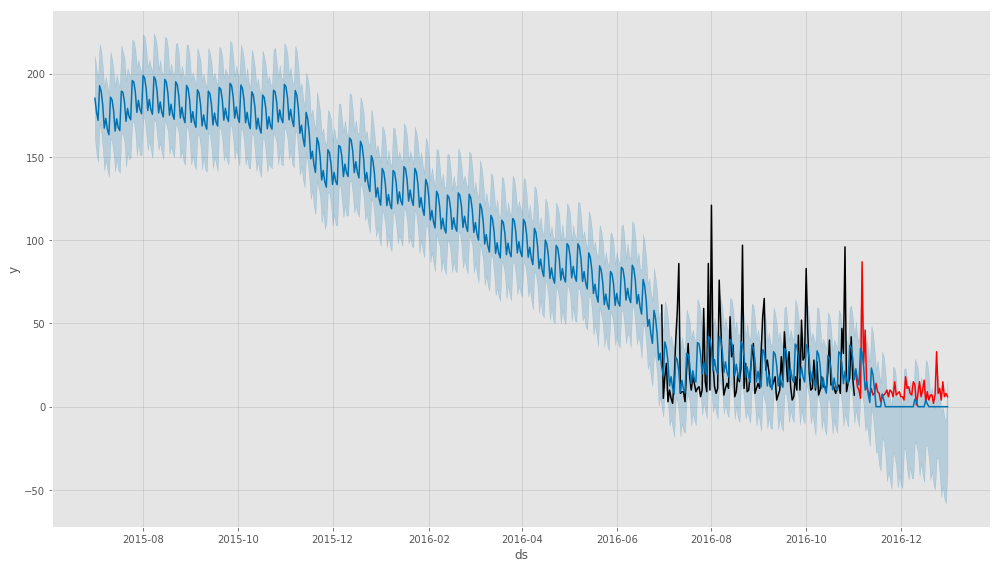

(7, page_index          7
v0.3_full     61.1935
v0.3_val      68.6091
Name: 7, dtype: object)


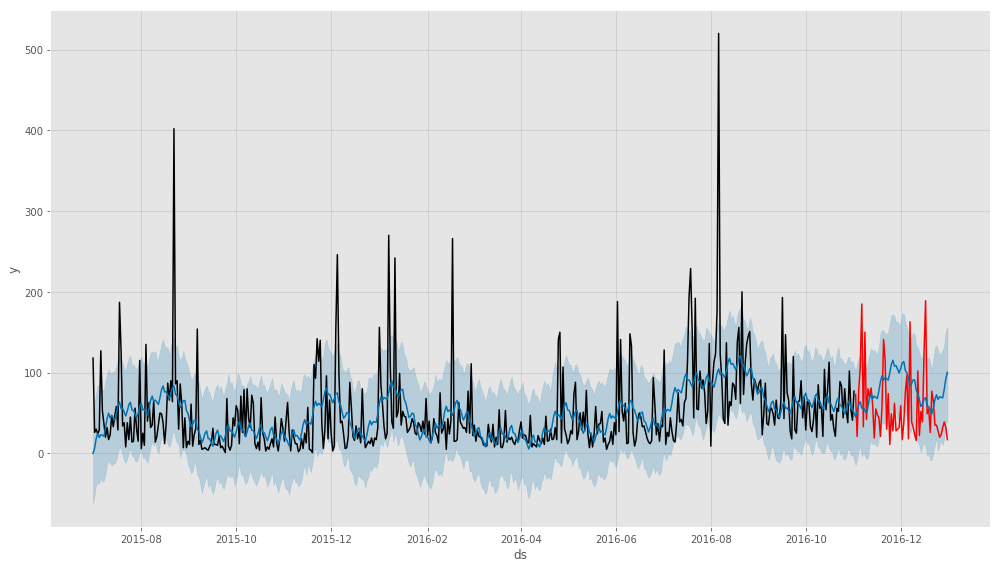

(8, page_index          8
v0.3_full     34.3191
v0.3_val      41.2204
Name: 8, dtype: object)


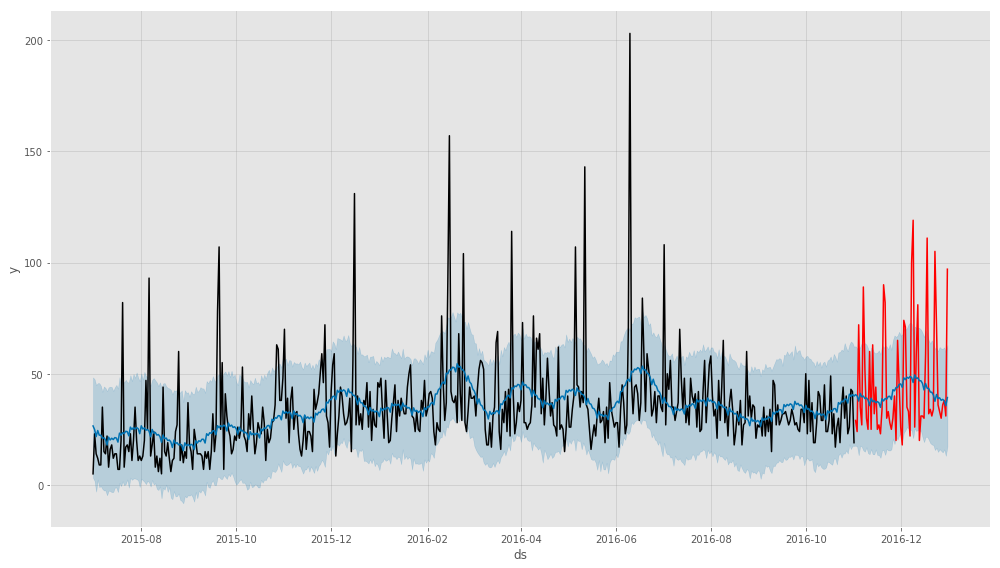

(9, page_index          9
v0.3_full      26.106
v0.3_val      29.1971
Name: 9, dtype: object)


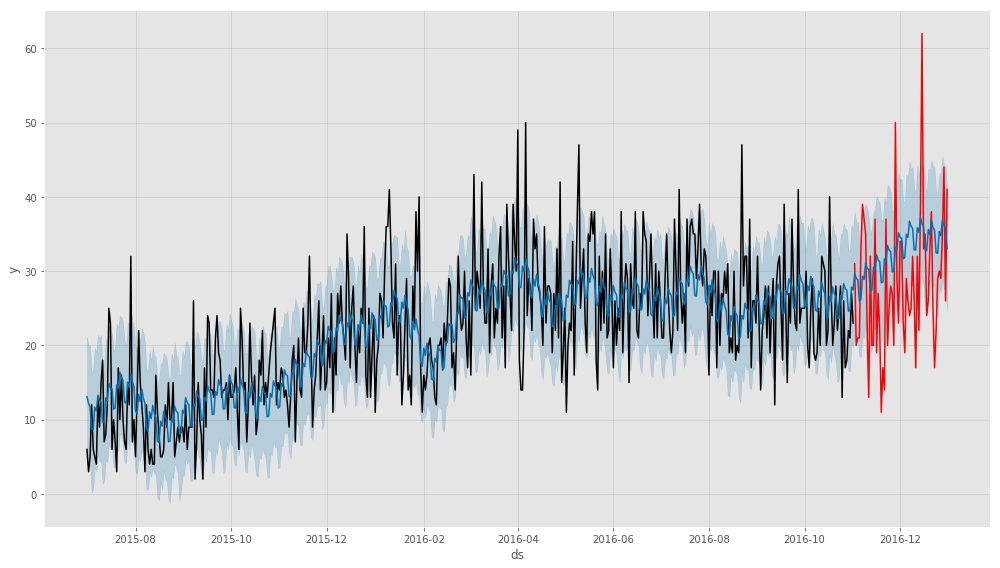

(10, page_index         10
v0.3_full      84.921
v0.3_val      65.5616
Name: 10, dtype: object)


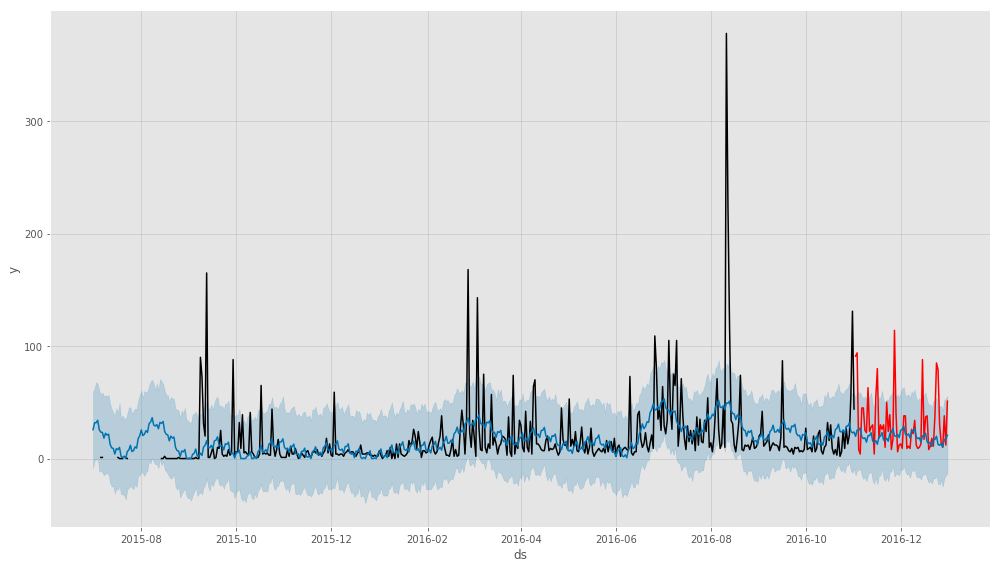

In [55]:
for row in val_results.iterrows():
    print(row)
    wiki.newphet.prophet_plot(pd.read_feather(PROPHET_PATH+VERSION+row[1][0]+'df.f'))
    plt.show()